In [609]:
import pandas as pd
import numpy as np
import re
import string
import unicodedata
import plotly_express as px
import plotly.io as pio
from sklearn import preprocessing
import pandas_profiling
import datetime
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt 
from sklearn import preprocessing
import warnings
import math
import plotly.express as px
import statsmodels
import scipy
import sklearn
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from statsmodels.tsa.statespace.sarimax import SARIMAX


warnings.filterwarnings("ignore")

# scipy
print('scipy: %s' % scipy.__version__)
# numpy
print('numpy: %s' % np.__version__)
# matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
print('pandas: %s' % pd.__version__)
# scikit-learn
print('sklearn: %s' % sklearn.__version__)
# statsmodels
print('statsmodels: %s' % statsmodels.__version__)
#print('unicodedata: %s' % unicodedata.__version__)

scipy: 1.4.1
numpy: 1.18.2
matplotlib: 3.2.1
pandas: 1.0.3
sklearn: 0.22.2.post1
statsmodels: 0.11.1


In [631]:
#verificar feriados 
def isHoliday(dia,mes):
    if dia == 1:
        if mes == 1 or mes ==5:
            return(True)
    if (dia ==2 or dia==15) and mes==11:
        return(True)
    if (dia ==7 or dia==20) and mes == 9:
        return(True)
    if mes == 4 and dia==21:
        return(True)    
    if mes==10 and (dia==12):
        return(True)
    if mes==12 and (dia ==25 or dia ==24):
        return(True)
    if mes==12 and dia==31:
        return(True)
    return(False)   

def AdjustFeriado(x):
    #print(x)
    if x['Feriado'] == 0 or x['Feriado'] == 1:
        return(x['Feriado'])
       # print('else')
       # print(x['Feriado'] >=0)
    else:
        dia = x['judgmentDate'].day
        mes = x['judgmentDate'].month 
        feriado = 0 if isHoliday(dia,mes) == True else 1
        return(feriado)
    
def AdjustWeekDay(x):    
    if x['weekDay'] > 0:
        return(x['weekDay'])
    else:
        return(x['judgmentDate'].weekday())        
    
def AdjustWeekType(x):    
    if x['weekType'] > 0:
        return(x['weekType'])
    else:
        weekType = 1 if x['judgmentDate'].weekday() <5 else 0
        return(weekType)     

In [632]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [705]:
#carrega
df_count_day_type = pd.read_csv('./data_joao/df_count_day_type_modificado.csv',sep=",")#,parse_dates=['judgmentDate'])
df_count_week_day_type = pd.read_csv('./data_joao/df_count_week_day_type_modificado.csv',sep=",")
df_count_year_month_type = pd.read_csv('./data_joao/df_count_year_month_type_modificado.csv',sep=",")

#cria indice
df_count_day_type.index = pd.to_datetime(df_count_day_type['judgmentDate'])
df_count_year_month_type.index = pd.to_datetime(df_count_year_month_type['yearMonth'])

#deleta colunas que sobraram da importacao e da criacao do indice
del df_count_day_type['Unnamed: 0']
del df_count_week_day_type['Unnamed: 0']
del df_count_year_month_type['Unnamed: 0']
del df_count_day_type['judgmentDate']
del df_count_year_month_type['yearMonth']

#calcula o total do dia
df_count_day_type['total'] = df_count_day_type.groupby(['judgmentDate'])['count'].agg('sum')
#salva as informacoes que nao serao pivotadas
ref = df_count_day_type[['weekDay','weekType','Feriado','total']]
#realiza o pivot
df_count_day_typeGRP = df_count_day_type.pivot(columns='type', values='count').fillna(0)

#transforma tudo pra int (count)
for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)
        
#faz o merge com as que foram salvas antes do pivot        
df_count_day_typeGRP = pd.merge(df_count_day_typeGRP,ref,on='judgmentDate',how='left')
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate').drop_duplicates()

#remove duplicadas e nulas pra fazer a frequencia diaria
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP = df_count_day_typeGRP.drop_duplicates()
df_count_day_typeGRP = df_count_day_typeGRP.dropna()


df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP['Feriado'].apply( lambda x: 0 if x==True else 1)
df_count_day_typeGRP['weekType'] = pd.get_dummies(df_count_day_typeGRP['weekType'])
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D') #precisa pois abaixo seto os que faltam

#reseta o indice agora com todos os dias inclusive vazios e seta as informaçoes das datas novas (sem dados)
df_count_day_typeGRP = df_count_day_typeGRP.reset_index()    
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP.apply(AdjustFeriado,axis=1)
df_count_day_typeGRP['weekDay'] = df_count_day_typeGRP.apply(AdjustWeekDay,axis=1)
df_count_day_typeGRP['weekType'] = df_count_day_typeGRP.apply(AdjustWeekType,axis=1)

#volta ao estado normal (com indice e frequencia)
df_count_day_typeGRP.index = df_count_day_typeGRP['judgmentDate']
del df_count_day_typeGRP['judgmentDate']
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D')

#seta para zerado as datas que nao existiam antes 
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)

for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)


In [752]:
df_count_day_typeGRP = df_count_day_typeGRP['2014-01-01':]
df_count_day_typeGRP.head(3)

,Agravo,Agravo Embargos Infringentes,Agravo Inominado,Agravo Interno,Agravo Lei,Agravo Regimental,Agravo de Instrumento,Agravo de Instrumento em Recurso Extraordinario,Agravo de Petição,Agravo em Execução,...,Suspenção de Liminar ou Antecipação de Tutela,Termo Circunstanciado,Tutela Antecipada Antecedente,Tutela Cautelar Antecedente,Tutela Provisoria,Uniformização de Jurisprudência,weekDay,weekType,Feriado,total
judgmentDate,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,1,0,0
2014-01-02,0,0,0,0,0,0,12,0,0,0,...,0,0,0,0,0,0,3,1,1,15
2014-01-03,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,4,1,1,4


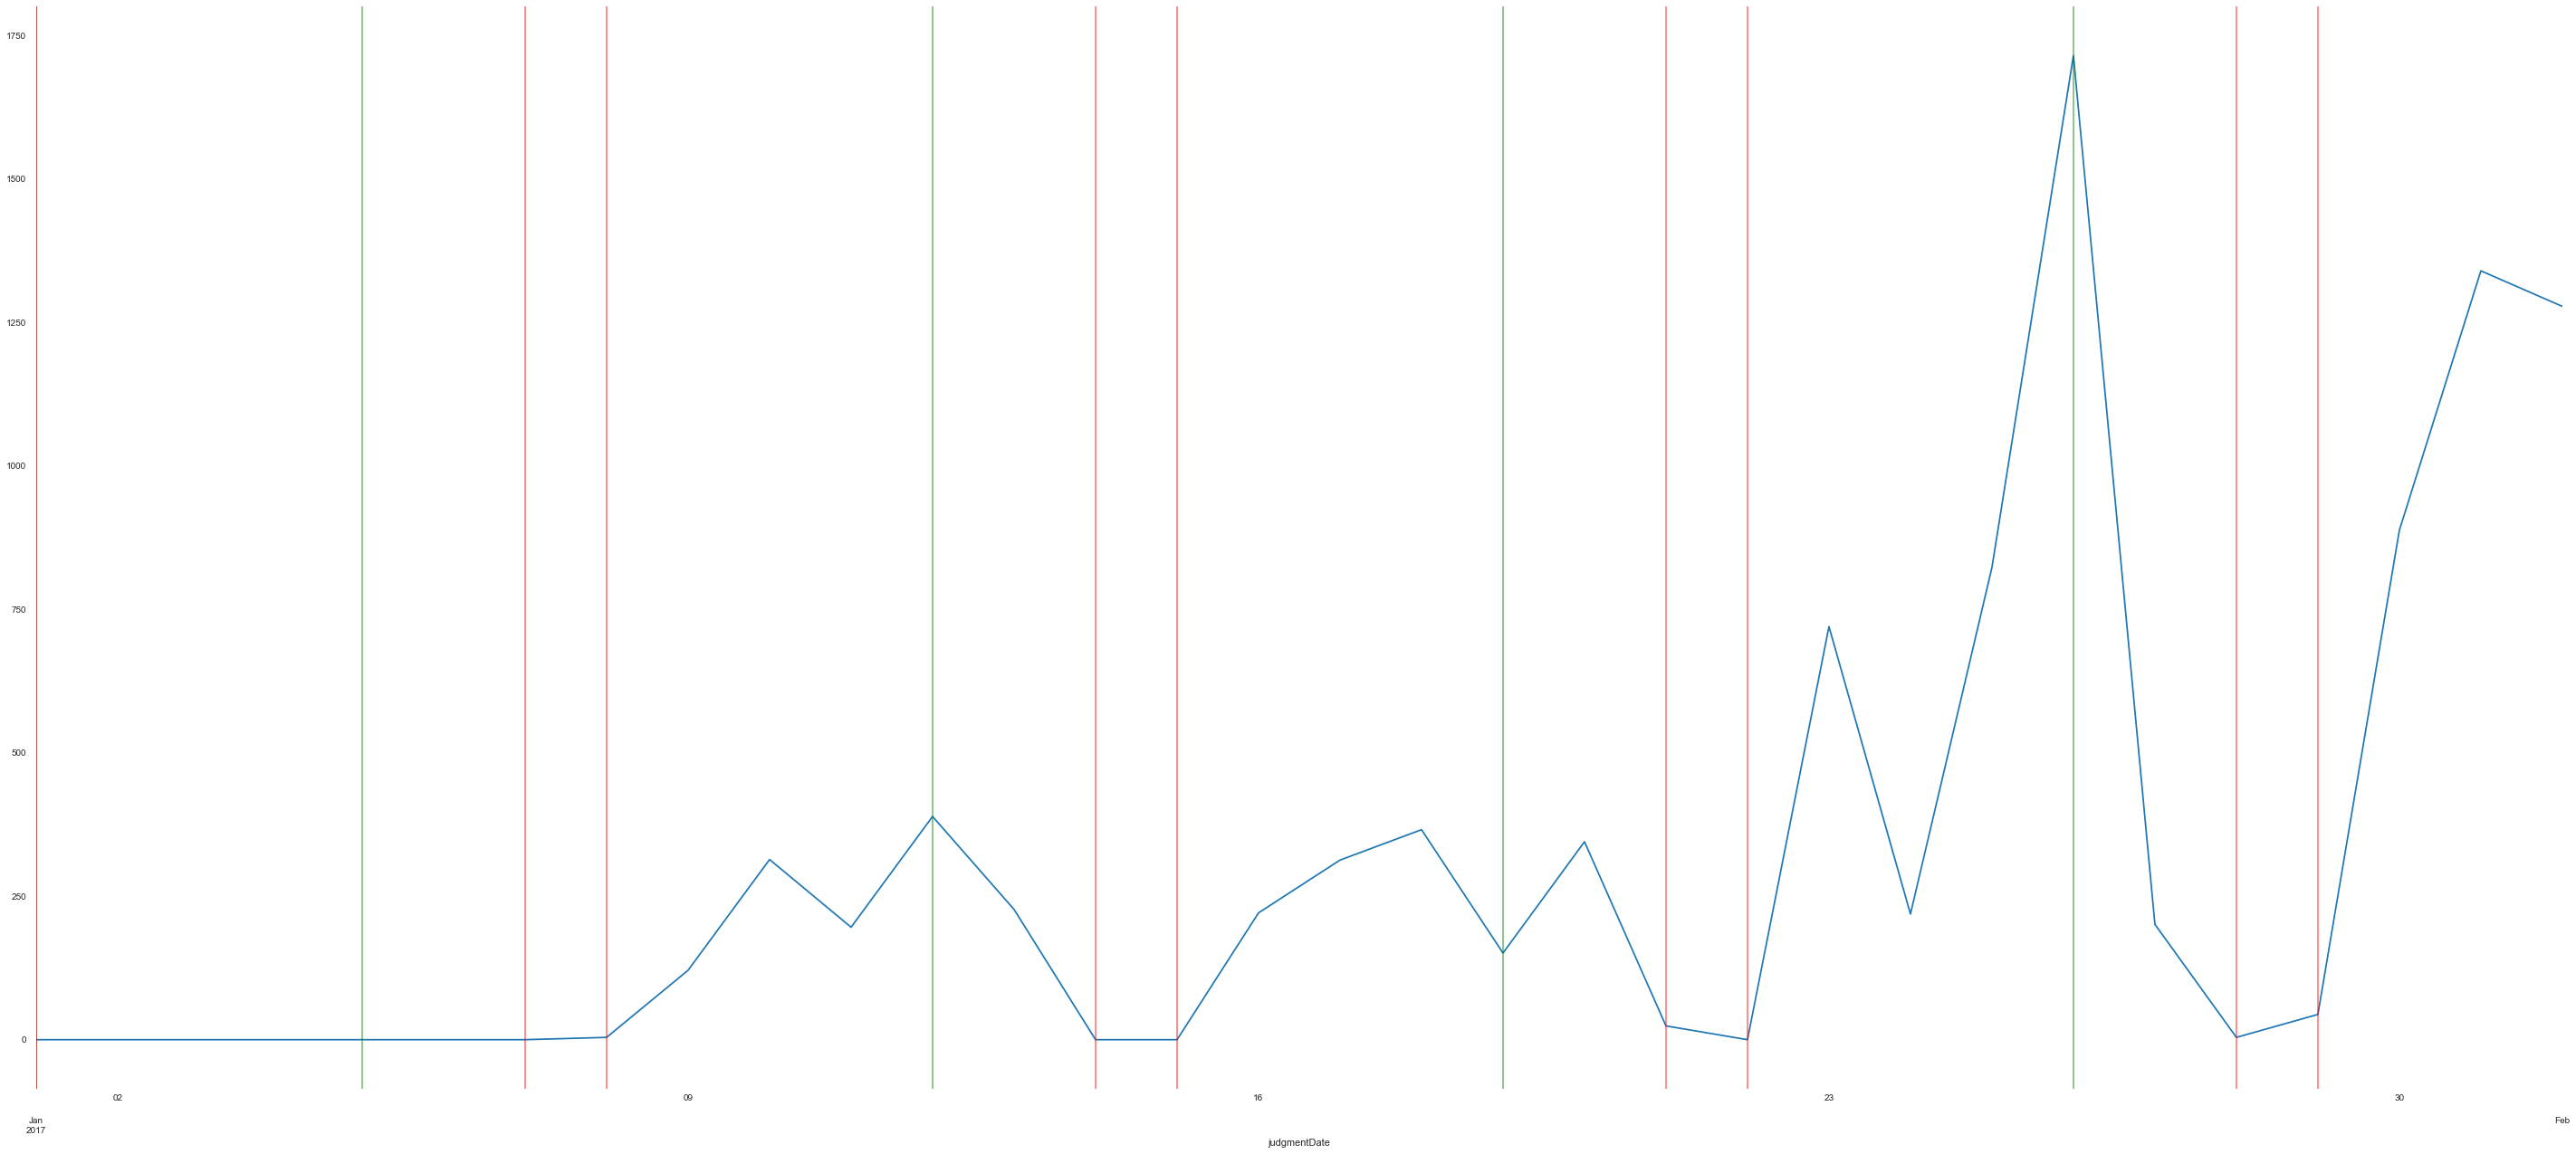

In [817]:
#df_count_day_typeGRP['total']['2017-01-01':].plot(figsize=(18,8))

ax = df_count_day_typeGRP['total']['2017-01-01':'2017-02-01'].plot(figsize=(50,22))

for dia in df_count_day_typeGRP.query('Feriado==0').index:    
    ax.axvline(x=dia,color='black',alpha=0.5)
    
for dia in df_count_day_typeGRP.query('weekType==0').index:    
    ax.axvline(x=dia,color='red',alpha=0.5)
    
for dia in df_count_day_typeGRP.query('weekDay==3').index:    
    ax.axvline(x=dia,color='green',alpha=0.5)



In [818]:
print(df_count_day_typeGRP.index)

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2017-12-20', '2017-12-21', '2017-12-22', '2017-12-23',
               '2017-12-24', '2017-12-25', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='judgmentDate', length=1459, freq='D')


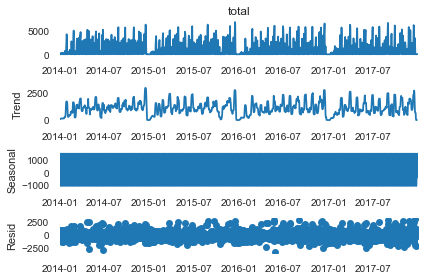

In [820]:
result = seasonal_decompose(df_count_day_typeGRP['total'])
result.plot();

In [796]:
adf_test(df_count_day_typeGRP['Agravo'])


Augmented Dickey-Fuller Test: 
ADF test statistic     -6.909101e+00
p-value                 1.225422e-09
# lags used             2.100000e+01
# observations          1.437000e+03
critical value (1%)    -3.434909e+00
critical value (5%)    -2.863553e+00
critical value (10%)   -2.567842e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [711]:
#display(df_count_day_typeSemGRP.groupby('Feriado').count())
#display(df_count_day_typeSemGRP.groupby('weekType').count())

In [823]:
auto_arima(df_count_day_typeGRP['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1459
Model:             SARIMAX(5, 0, 2)x(2, 0, 2, 7)   Log Likelihood              -12150.432
Date:                           Tue, 05 May 2020   AIC                          24326.864
Time:                                   22:55:39   BIC                          24395.576
Sample:                                        0   HQIC                         24352.497
                                          - 1459                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    643.0625    183.767      3.499      0.000     282.885    1003.240
ar.L1         -1.1299      0.036    -31.315      0.000      -1.201      -1.059
ar.L2         -0.1304      0.042     -3.086      0.002      -0.213      -0.048
ar.L3          0.2575      0.054      4.732      0.000       0.151       0.364
ar.L4         -0.2115      0.081     -2.603      0.009      -0.371      -0.052
ar.L5         -0.1436      0.052     -2.736      0.006      -0.246      -0.041
ma.L1          1.6852      0.026     65.947      0.000       1.635       1.735
ma.L2          0.9256      0.026     35.251      0.000       0.874       0.977
ar.S.L7       -0.0789      0.059     -1.339      0.181      -0.194       0.037
ar.S.L14       0.9106      0.054     16.864      0.000       0.805       1.016
ma.S.L7        0.2697      0.072      3.736      0.000       0.128       0.411
ma.S.L14      -0.7190      0.061    -11.742      0.000      -0.839      -0.599
sigma2      1.191e+06    4.7e+04     25.321      0.000     1.1e+06    1.28e+06
===================================================================================
Ljung-Box (Q):                      147.38   Jarque-Bera (JB):               536.46
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             0.92
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [824]:
train = df_count_day_typeGRP[:'2017-01-01']
test = df_count_day_typeGRP['2017-01-01':]
print(train['total'].count(),test['total'].count())

1097 363


In [828]:
model = SARIMAX(train['total'],order=(5,0,2),seasonal_order=(2, 0, 2, 7),enforce_invertibility=False)
#model = SARIMAX(train['total'],order=(3,0,3),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                 1097
Model:             SARIMAX(5, 0, 2)x(2, 0, 2, 7)   Log Likelihood               -9091.084
Date:                           Tue, 05 May 2020   AIC                          18206.169
Time:                                   22:59:58   BIC                          18266.173
Sample:                               01-01-2014   HQIC                         18228.872
                                    - 01-01-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5141      0.043     12.021      0.000       0.430       0.598
ar.L2          0.9682      0.065     14.971      0.000       0.841       1.095
ar.L3         -0.5509      0.103     -5.375      0.000      -0.752      -0.350
ar.L4          0.0256      0.047      0.541      0.588      -0.067       0.118
ar.L5          0.0429      0.094      0.454      0.650      -0.142       0.228
ma.L1         -0.0026      0.030     -0.088      0.930      -0.061       0.056
ma.L2         -0.9983      0.030    -32.995      0.000      -1.058      -0.939
ar.S.L7        0.0511      0.131      0.391      0.696      -0.205       0.307
ar.S.L14       0.9471      0.131      7.230      0.000       0.690       1.204
ma.S.L7       -0.0336      0.140     -0.240      0.811      -0.308       0.241
ma.S.L14      -0.9095      0.139     -6.528      0.000      -1.183      -0.636
sigma2       1.25e+06   1.96e-08   6.37e+13      0.000    1.25e+06    1.25e+06
===================================================================================
Ljung-Box (Q):                       91.72   Jarque-Bera (JB):               406.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.63
Prob(H) (two-sided):                  0.57   Kurtosis:                         5.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.09e+29. Standard errors may be unstable.
"""

In [829]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMASARIMAX(3, 1, 2)(1, 0, [1], 7) Predictions')

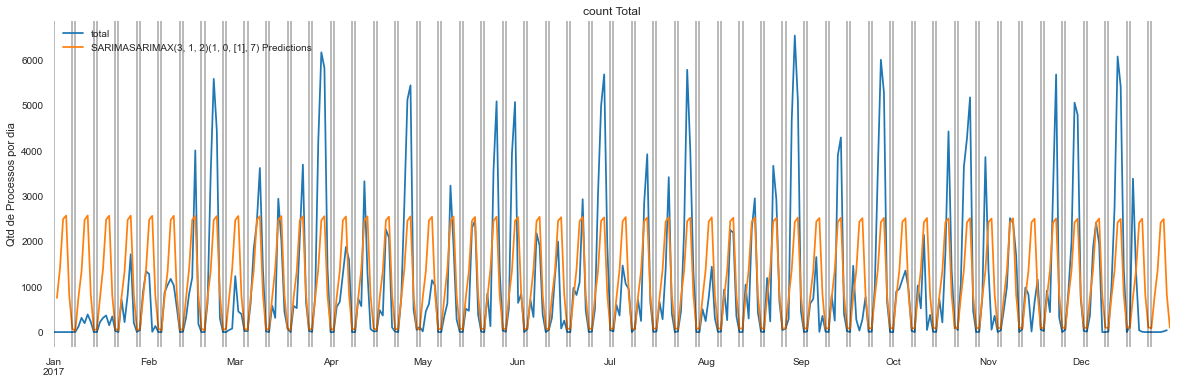

In [832]:
# Plot predictions against known values
title='count Total'
ylabel='Qtd de Processos por dia'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(20,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('weekType==0').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

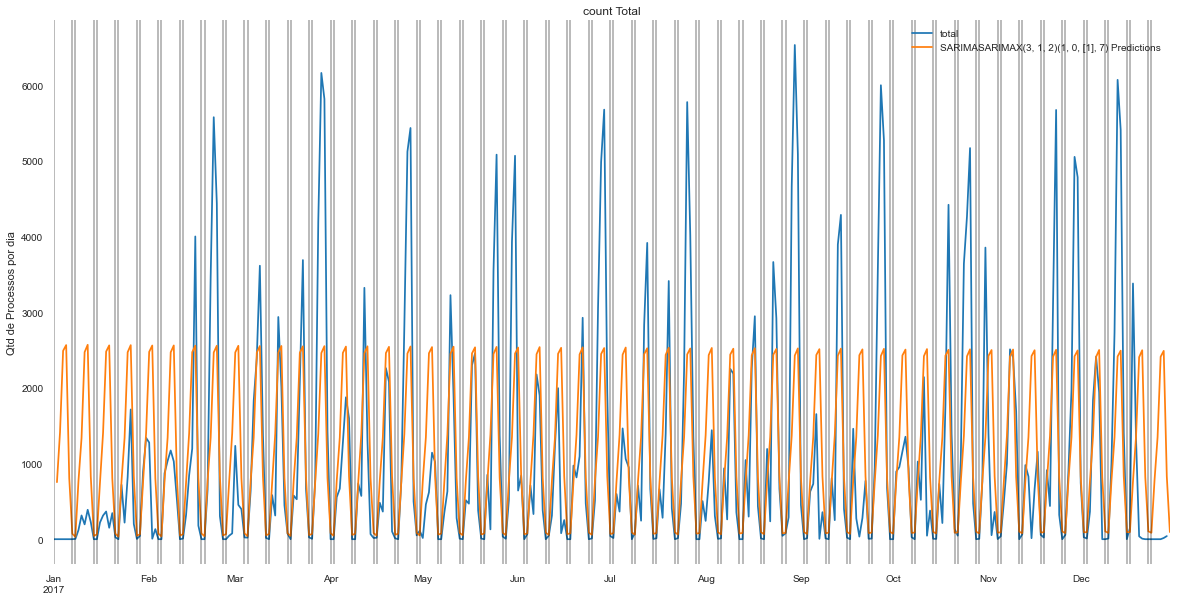

In [833]:
# Plot predictions against known values
title='count Total'
ylabel='Qtd de Processos por dia'
xlabel=''

ax = test['total']['2017-01-01':].plot(legend=True,figsize=(20,10),title=title)
predictions['2017-01-01':].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test['2017-01-01':].query('weekType==0').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

In [834]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

error1 = mean_squared_error(test['total'], predictions)
error2 = rmse(test['total'], predictions)

print(f'SARIMASARIMA(3, 1, 2)(1, 0, [1], 7) MSE Error: {error1:11.10}')
print(f'SARIMASARIMA(3, 1, 2)(1, 0, [1], 7) RMSE Error: {error2:11.10}')

#SARIMA(1,0,0)(2,0,0,7) MSE Error: 2071263.637
#SARIMA(1,0,0)(2,0,0,7) RMSE Error: 1439.188534

SARIMASARIMA(3, 1, 2)(1, 0, [1], 7) MSE Error:  2118738.05
SARIMASARIMA(3, 1, 2)(1, 0, [1], 7) RMSE Error: 1455.588558


In [835]:
model = SARIMAX(train['total'],exog=train[['weekType','weekDay']],order=(5,0,2),seasonal_order=(2, 0, 2, 7),enforce_invertibility=False)
#model = SARIMAX(train['total'],exog=train['weekType'],order=(3,0,3),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                 1097
Model:             SARIMAX(5, 0, 2)x(2, 0, 2, 7)   Log Likelihood               -9092.029
Date:                           Tue, 05 May 2020   AIC                          18212.057
Time:                                   23:00:36   BIC                          18282.062
Sample:                               01-01-2014   HQIC                         18238.544
                                    - 01-01-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weekType    1498.5641    828.526      1.809      0.070    -125.316    3122.444
weekDay       24.2483    248.290      0.098      0.922    -462.390     510.887
ar.L1         -0.1397      0.073     -1.918      0.055      -0.282       0.003
ar.L2         -0.6094      0.074     -8.190      0.000      -0.755      -0.464
ar.L3          0.4314      0.092      4.707      0.000       0.252       0.611
ar.L4         -0.0915      0.073     -1.249      0.212      -0.235       0.052
ar.L5          0.0020      0.097      0.020      0.984      -0.189       0.193
ma.L1          0.6434      0.062     10.374      0.000       0.522       0.765
ma.L2          0.9236      0.064     14.395      0.000       0.798       1.049
ar.S.L7        0.0325      0.642      0.051      0.960      -1.225       1.290
ar.S.L14       0.9665      0.642      1.506      0.132      -0.291       2.224
ma.S.L7       -0.0095      0.649     -0.015      0.988      -1.282       1.263
ma.S.L14      -0.9422      0.636     -1.482      0.138      -2.188       0.304
sigma2      1.319e+06      1.208   1.09e+06      0.000    1.32e+06    1.32e+06
===================================================================================
Ljung-Box (Q):                       69.67   Jarque-Bera (JB):               337.16
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.56
Prob(H) (two-sided):                  0.54   Kurtosis:                         5.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.34e+21. Standard errors may be unstable.
"""


# ------------------------------------------------

In [840]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['weekType','weekDay']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMASARIMAX(3, 1, 2)(1, 0, [1], 7) Predictions')

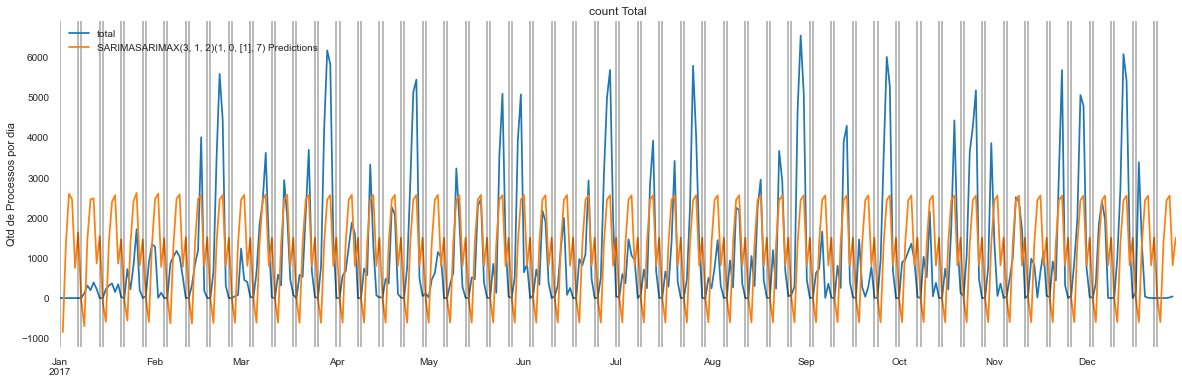

In [841]:
# Plot predictions against known values
title='count Total'
ylabel='Qtd de Processos por dia'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(20,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('weekType==0').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

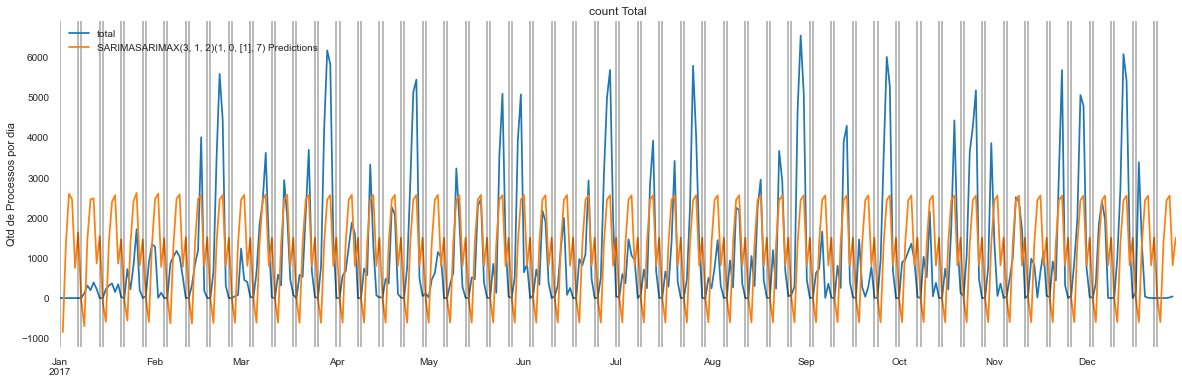

In [842]:

title='count Total'
ylabel='Qtd de Processos por dia'
xlabel=''

ax = test['total']['2017-01-01':].plot(legend=True,figsize=(20,6),title=title)
predictions['2017-01-01':].plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test['2017-01-01':].query('weekType==0').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

In [843]:
# Print values from SARIMA above
print(f'SARIMASARIMA(3, 1, 2)(1, 0, [1], 7) MSE Error: {error1:11.10}')
print(f'SARIMASARIMA(3, 1, 2)(1, 0, [1], 7) RMSE Error: {error2:11.10}')
print()

error1x = mean_squared_error(test['total'], predictions)
error2x = rmse(test['total'], predictions)

# Print new SARIMAX values
print(f'SARIMASARIMAX(3, 1, 2)(1, 0, [1], 7) MSE Error: {error1x:11.10}')
print(f'SARIMASARIMAX(3, 1, 2)(1, 0, [1], 7) RMSE Error: {error2x:11.10}')

#SARIMASARIMA(3, 1, 2)(1, 0, [1], 7) MSE Error: 2071263.637
#SARIMASARIMA(3, 1, 2)(1, 0, [1], 7) RMSE Error: 1439.188534

#SARIMASARIMAX(3, 1, 2)(1, 0, [1], 7) MSE Error: 2127453.131
#SARIMASARIMAX(3, 1, 2)(1, 0, [1], 7) RMSE Error: 1458.579148

SARIMASARIMA(3, 1, 2)(1, 0, [1], 7) MSE Error:  2118738.05
SARIMASARIMA(3, 1, 2)(1, 0, [1], 7) RMSE Error: 1455.588558

SARIMASARIMAX(3, 1, 2)(1, 0, [1], 7) MSE Error: 2172967.995
SARIMASARIMAX(3, 1, 2)(1, 0, [1], 7) RMSE Error: 1474.099045
